In [ ]:
!git clone https://github.com/Avazork/NN.git

fatal: destination path 'NN' already exists and is not an empty directory.


Начнем с того, что заодно будем считывать и дату. Впоследствии допишем её присоединение к матрице в свой трансформер.

In [ ]:
from lxml import etree

from typing import List, Tuple

def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str], List[int]]:
    texts = []
    labels = []
    dates = []
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    root = etree.fromstring(xml_data)
    for database in root.getchildren():
        if database.tag == 'database':
            for table in database.getchildren():
                if table.tag != 'table':
                    continue
                new_text = None
                new_label = None
                new_data = None
                for column in table.getchildren():
                    if column.get('name') == 'text':
                        new_text = str(column.text).strip()
                        if new_label is not None:
                            break
                    elif column.get('name') not in {'id', 'twitid', 'date'}:
                        if new_label is None:
                            label_candidate = str(column.text).strip()
                            if label_candidate in {'0', '1', '-1'}:
                                new_label = 'negative' if label_candidate == '-1' else \
                                    ('positive' if label_candidate == '1' else 'neutral')
                                if new_text is not None:
                                    break
                    elif column.get('name') == 'date':
                      new_data = int(column.text)
                if (new_text is None) or (new_label is None):
                    raise ValueError('File `{0}` contains some error!'.format(file_name))
                texts.append(new_text)
                labels.append(new_label)
                dates.append(new_data)
            break
    return texts, labels, dates
texts, labels, dates = load_sentirueval_2016('/content/NN/bank_train_2016.xml')
print('Number of texts is {0}, number of labels is {1}, number of dates is {2}'.format(len(texts), len(labels), len(dates)))

Number of texts is 9392, number of labels is 9392, number of dates is 9392


Дальше какое-то количество кода останется без изменений.

In [ ]:
import random

In [ ]:
for idx in random.choices(list(range(len(texts))), k=20):
    print('{0} => {1}'.format(labels[idx], texts[idx])) # выводим 20 любых текстов с меткой из набора train

neutral => кредитка альфа банк http://t.co/91mY1ZjpFR
negative => RT @BillesAkash: Нужно было что-то сделать в альфа-клике, но в процессе ввода паролей заблокировал аккаунт. Потом звонил, чтобы разблокиро
neutral => http://t.co/aWDHPHOp8Q альфа банк в южно сахалинске заказать кредитную карту http://t.co/DgcBXZzc4d
neutral => http://t.co/oHxMXoCfZx россельхозбанк кредиты кострома
negative => RT @sd0107: В 87 г. бабуля открыла на меня счёт на 1000 руб. В 2014 году я счастливый обладатель 3089.26 руб. Спасибо, @sberbank http://t.c…
positive => Внедрение новых видов кредитов сбербанк http://t.co/FzEr6ugQbU
neutral => карта моментум сбербанк инструкция 0 0 http://t.co/Gizvwa7nrL
neutral => банк уралсиб магнитогорск кредит http://t.co/m6skrx9Jeb
positive => RT @TracyErnst4: Сбербанк и ВТБ пообещали выполнить обязательства перед клиентами
neutral => http://t.co/ZMCgjC8fDj Взять кредит в райффайзенбанке в омске
neutral => Сибирский Сбербанк: потребительские кредиты – Олимпийская лотерея http:/

In [ ]:
positive_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'positive']
negative_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'negative']
neutral_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'neutral']

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

Хорошо бы написать свой токенайзер с учетом лематизации.

In [ ]:
! pip install spacy-udpipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy_udpipe

spacy_udpipe.download("ru")
nlp = spacy_udpipe.load("ru")
doc = nlp("Весна! Крестьянин, торжествуя, на дровнях обновляет путь.")
for token in doc:
  print(token.text, token.lemma_)

Already downloaded a model for the 'ru' language
Весна весна
! !
Крестьянин крестьянин
, ,
торжествуя торжествовать
, ,
на на
дровнях дровень
обновляет обновлять
путь путь
. .


In [ ]:
doc = nlp("Мы выплавляем больше стали")
for token in doc:
  print(token.text, token.lemma_)

Мы мы
выплавляем выплавлять
больше больше
стали стать


Проблема! Впрочем, и случаи такие редки, и среди реально эмоционально окрашенных слов едва ли много омонимов. Перейдём к токенизатору. 

In [ ]:
def my_lemma_tokenize(text:str) -> List[str]:
  list_of_words = []
  doc = nlp(text)
  for token in doc:
    list_of_words.append(token.lemma_)
  return list_of_words

In [ ]:
my_lemma_tokenize('Ты меня никогда не забудешь, ты меня никогда не увидишь')

['ты',
 'я',
 'никогда',
 'не',
 'забыть',
 ',',
 'ты',
 'я',
 'никогда',
 'не',
 'видеть']

In [ ]:
vectorizer = CountVectorizer(lowercase=True, tokenizer=my_lemma_tokenize) 

In [ ]:
vectorizer.fit(texts)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function my_lemma_tokenize at 0x7f20841c8170>)

In [ ]:
print(vectorizer.get_feature_names()[0:50])

['!', '"', '#', '#1000aday', '#1042', '#13268', '#171', '#187', '#24', '#40', '#41', '#8220', '#8221', '#8230', '#card', '#ekb', '#ff', '#g', '#hny', '#in', '#ipad', '#iphone', '#k', '#klerk', '#mol', '#moneyzzz', '#motox', '#msci', '#nsk', '#pyd', '#r', '#rt', '#ru', '#ru_ff', '#the', '#ua', '#vk', '#wall', '#ykt', '#аст', '#бут', '#в', '#ввп', '#вс', '#все', '#втб', '#втб24', '#втбый', '#вэб', '#гд']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(len(vectorizer.get_feature_names()))

16157


In [ ]:
X = vectorizer.transform(texts)

In [ ]:
print(f'Текст: {texts[10]}\n')

print(X[1])

Текст: ДЕЛО -  На 1 млрд грн ушел в минус Райффайзен Банк Аваль и была докапитализирована украинская "дочка" ВТБ

  (0, 354)	1
  (0, 6976)	1
  (0, 10035)	1
  (0, 11302)	1
  (0, 11589)	1
  (0, 12026)	1
  (0, 12545)	1


In [ ]:
for idx in random.choices(list(range(len(texts))), k=20):
    print('{0} => {1}'.format(labels[idx], texts[idx]))

neutral => втб 24 тольятти кредиты http://t.co/QVFQclOlNJ
neutral => моментальный кредит сбербанк http://t.co/yQbR0ZOcCG
neutral => Кредитную карту альфа банк http://t.co/poETAI5b9O
neutral => Потребительский кредит газпромбанка в омске http://t.co/CHRTSirmYo
neutral => банк сбербанк зеленоград http://t.co/8LF99kqKhr
neutral => Взять кредит в альфа банке саратов
neutral => RT @cymysinybuxo: фича или баг? зная номер сберкарты в сбербанке — можно узнать сколько на ней денег.
neutral => сбербанк досрочное погашение потребительского кредита http://t.co/jdhEbMooY0
neutral => Как взять кредит для организации сбербанк http://t.co/gzX9YctdbA
neutral => банк втб 24 кредиты http://t.co/H2eLAN6T80
negative => Под санкции ЕС официально попали Сбербанк, ВТБ, Газпромбанк, ВЭБ и Россельхозбанк
neutral => сбербанк кредит по двум документам http://t.co/ADcOcjIY1z
neutral => Суд признал сотрудницу Сбербанка Лохову жертвой сексизма  Да, в Лондоне есть Сбербанк
negative => RT @495Sergo: @sberbank @AndreyA

Теперь с помощью регулярных выражений учтём наличие телеграм-канала. Ссформируем список твитов, в которых он есть, взглянем на него и сперва просто убедимся в том, что подавляющее большинство твитов со ссылками нейтральны.

In [ ]:
import re

tg_channel = re.compile('(http[s]?:)?\/\/t\.co')
tg_tweets = []
tg_labels = []
for idx in range(len(texts)):
  if tg_channel.search(texts[idx]) is not None:
    tg_tweets.append(texts[idx])
    tg_labels.append(labels[idx])

In [ ]:
for idx in random.choices(list(range(len(tg_tweets))), k=20):
    print('{0} => {1}'.format(tg_labels[idx], tg_tweets[idx]))

neutral => дневник по производственной практике в сбербанке http://t.co/YaMp39Z2I0
neutral => http://t.co/14dY9LVVeV Взять кредит на технику в альфа банке
neutral => http://t.co/HDKQCmUy9T Взять кредит в райффайзенбанке
neutral => http://t.co/smU2bT3v7V Как оформить кредит в россельхозбанк
neutral => Банкоматы в олимпийском Сочи оснастят интерфейсом на китайском и французском: Сбербанк оснастит банкоматы в Со... http://t.co/A7pNR3NDgJ
neutral => RT @fahevujijoh: Сбербанк банк клиент инструкция http://t.co/pUyVzYd2EN
neutral => #news Четыре тысячи вкладчиков банка "Аскольд" получат возмещение по вкладам: АСВ выбрало ВТБ 24 банк... http://t.co/YfNsGlEqNF #novosti
neutral => кредит 20 тысяч в сбербанке http://t.co/YiyvPWd0e6
neutral => Потребительский кредит ульяновск сбербанк http://t.co/RaLNbNd4uf
neutral => автокредит в россельхозбанке рассчитать http://t.co/WIDxmcv6iN
neutral => Минимальная сумма кредита в альфа банке http://t.co/o5bZ2AFPg5
neutral => Казань сбербанк кредитный отдел h

Сейчас попробуем учесть эмоциональность лексики. Положимся на соответствующий найденный в интернете словарь и составим списки слов всех тональностей.

In [ ]:
with open("/content/NN/rusentilex_2017.txt", "r", encoding="utf-8") as file:
  positive_list=[]
  negative_list=[]
  neutral_list=[]
  for row in file.readlines():
    if row[0] == '!':
      pass
    else:
      row = row.split(', ')
      if 'positive' in row:
        positive_list.append(row[0])
      elif 'negative' in row:
        negative_list.append(row[0])
      elif 'neutral' in row:
        neutral_list.append(row[0])


In [ ]:
print (negative_list)

['аборт', 'абортивный', 'абракадабра', 'абсурд', 'абсурдность', 'абсурдный', 'авантюра', 'авантюризм', 'авантюрист', 'авантюристический', 'авантюристка', 'авантюристский', 'авантюрный', 'аварийность', 'аварийный', 'авария', 'авиакатастрофа', 'авиакрушение', 'авианалет', 'авиаудар', 'авиационный налет', 'авитаминоз', 'авитаминозный', 'аврал', 'авральный', 'автовор', 'автоматная очередь', 'автоматный огонь', 'автомобильная пробка', 'автоподстава', 'авторитаризм', 'авторитарность', 'авторитарный', 'авторитет падает', 'авторитет снижается', 'авторитет снизился', 'авторитет упал', 'авторитетом не пользоваться', 'автотрасса перекрыта', 'автоугон', 'автоугонщик', 'агент иностранной разведки', 'агитка', 'агонизировать', 'агония', 'агрессивность', 'агрессивный', 'агрессия', 'агрессор', 'агрессорский', 'ад', 'административное воздействие', 'административное давление', 'административные меры', 'административный барьер', 'адов', 'адовый', 'адский', 'ажиотаж', 'ажиотажный', 'ажитация', 'алкатель', 

А теперь сделаем следующую вещь: будем сверяться с уже составленными списками позитивной, негативной и нейтральной лексики - и считать количество слов из каждого списка для каждого текста. Оценим, как хорошо соотносится посчитанная "в лоб" тональность с реальным положением дел.

In [ ]:
c=0
for idx in range(len(texts)):
  doc = nlp(texts[idx].lower())
  positive=0
  negative=0
  neutral=0
  for token in doc:
    lemma=token.lemma_
    if lemma in positive_list:
      positive+=1
    if lemma in negative_list:
      negative+=1
    if lemma in neutral_list:
      neutral+=1
  emo_score = list(zip([k/len(doc) for k in [positive, negative, neutral]], ["positive", "negative", "neutral"]))
  for duo in emo_score:
    if duo[0] == max([i[0] for i in emo_score]):
      if duo[1] == labels[idx]:
        c+=1
print(c/len(texts))

0.9116269165247018


Ого! Хорошая точность, надо учесть.

Начнём вести учёт всех этих эвристик: добавим их в матрицу X.

In [ ]:
import numpy as np

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer().fit(X)
X_transformed = transformer.transform(X) 
print(f'Матрица:\nномер токена в словаре - tf слова\n{X_transformed[0]}')

Матрица:
номер токена в словаре - tf слова
  (0, 15341)	0.5324263568629732
  (0, 11584)	0.15073313902476837
  (0, 9627)	0.28144899379578087
  (0, 9449)	0.17206567469236075
  (0, 9299)	0.26390299681043833
  (0, 8257)	0.7178696059005679


In [ ]:
X_arr = X_transformed.toarray()
n,m = X_arr.shape
print(n,m)

9392 16157


Сперва немного доработаем тему с телеграм-каналами. По сути, допишем в матрицу ещё один столбец с единицами для твитов, где есть телега, и нулями, где её нет.

In [ ]:
tg_channel = re.compile('(http[s]?:)?\/\/t\.co')
X0 = np.zeros((n, 1))
for idx in range(len(texts)):
  if tg_channel.search(texts[idx]) is not None:
    X0[idx] = 1

Xnew = np.hstack((X_arr,X0))
print(Xnew)

[[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.22729295 ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Затем добавим ещё один столбец, где будем вести учёт эмоциональной лексики (то, что мы назвали подсчётом "в лоб"): туда запишем 0 для предположительно негативных. 0.5 для предположительно нейтральных и 1 для предположительно позитивных твитов. 

In [ ]:
X1 = np.zeros((n, 1))
for idx in range(len(texts)):
  doc = nlp(texts[idx].lower())
  positive=0
  negative=0
  neutral=0
  for token in doc:
    lemma=token.lemma_
    if lemma in positive_list:
      positive+=1
    if lemma in negative_list:
      negative+=1
    if lemma in neutral_list:
      neutral+=1
  emo_score = list(zip([k/len(doc) for k in [positive, negative, neutral]], ["positive", "negative", "neutral"]))
  for duo in emo_score:
    if max([i for i in emo_score]) != 0:
      if duo[0] == max([i[0] for i in emo_score]) and duo[0] != 0:
        if duo[1] == "positive":
          X1[idx] = 1
        elif duo[1] == "negative":
          X1[idx] = 0
        elif duo[1] == "neutral":
          X1[idx] = 0.5
    else:
      X1[idx] = 0.5

Xnew = np.hstack((Xnew,X1))
print(Xnew)

[[0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.22729295 ... 0.         1.         1.        ]
 [0.         0.         0.         ... 0.         1.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [ ]:
for idx in random.choices(list(range(len(texts))), k=10):
    print('{0} => {1}'.format(labels[idx], texts[idx]))
    print(Xnew[idx], '\n')

neutral => как оплатить кредит через сбербанк http://t.co/B9pb4YICq8
[0. 0. 0. ... 0. 1. 0.] 

negative => Под новые санкции ЕС попадают Сбербанк, ВТБ, Газпромбанк, Внешэкономбанк, Россельхозбанк http://t.co/b94Bdvo0PP
[0. 0. 0. ... 0. 1. 0.] 

positive => Сейчас зашла в сбер и за 5 мин все сделала. Не вероятно но факт:)
[0. 0. 0. ... 0. 0. 0.] 

neutral => Банк Москвы - корпоративный ролик http://t.co/qC7kmixdkP
[0. 0. 0. ... 0. 1. 0.] 

neutral => RT @SerovaElena: разобралась со Сбербанком, бегу в маминых сапожках на вокзал за билетами :)
[0. 0. 0. ... 0. 0. 0.] 

neutral => RT @rocimubudap: банк москвы в г кемерово потребительский кредит процентная ставка http://t.co/ldxh4Eynrq
[0.  0.  0.  ... 0.  1.  0.5] 

neutral => Кредиты малому бизнесу банки | РайффайзенБанк - Кредиты малому | МигКредит: Кредиты малому бизнесу банки... Кр... http://t.co/9NqpHKjLZw
[0. 0. 0. ... 0. 1. 0.] 

neutral => Как получить отсрочку по кредиту сбербанк http://t.co/Gs82eQ7tpH
[0. 0. 0. ... 0. 1. 0.] 

ne

Итак, мы учли дату, эмоциональную лексику и наличие телеграм-каналов. Начнём обучение?

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
cls = LogisticRegression(solver='liblinear', verbose=True)

In [ ]:
from sklearn.feature_selection import SelectPercentile, chi2
selector = SelectPercentile(chi2, percentile=20)

In [ ]:
selector.fit(Xnew, labels)

SelectPercentile(percentile=20, score_func=<function chi2 at 0x7f1f9c12c830>)

In [ ]:
tokens_with_IDF = list(zip(vectorizer.get_feature_names(), transformer.idf_))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
sorted_tokens_with_IDF = sorted(tokens_with_IDF, key=lambda it: (-it[1], it[0]))
for feature, idf in sorted_tokens_with_IDF[0:50]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => #1000aday
9.454573 => #1042
9.454573 => #13268
9.454573 => #171
9.454573 => #187
9.454573 => #24
9.454573 => #40
9.454573 => #41
9.454573 => #card
9.454573 => #ekb
9.454573 => #g
9.454573 => #hny
9.454573 => #k
9.454573 => #klerk
9.454573 => #moneyzzz
9.454573 => #motox
9.454573 => #nsk
9.454573 => #pyd
9.454573 => #ua
9.454573 => #ykt
9.454573 => #аст
9.454573 => #бут
9.454573 => #ввп
9.454573 => #вс
9.454573 => #все
9.454573 => #втб24
9.454573 => #втбый
9.454573 => #вэб
9.454573 => #гд
9.454573 => #ед
9.454573 => #екб
9.454573 => #жж
9.454573 => #з
9.454573 => #мск
9.454573 => #н-лат
9.454573 => #ндфл
9.454573 => #об
9.454573 => #пл
9.454573 => #пря
9.454573 => #псб
9.454573 => #псс
9.454573 => #пц
9.454573 => #сан
9.454573 => #т
9.454573 => #ткб
9.454573 => #уэк
9.454573 => #ый
9.454573 => #ь
9.454573 => #э�
9.454573 => #якт


In [ ]:
selected_tokens_with_IDF = [tokens_with_IDF[idx] for idx in selector.get_support(indices=True) - 2]
print(len(selected_tokens_with_IDF))

3231


In [ ]:
selected_and_sorted_tokens_with_IDF = sorted(selected_tokens_with_IDF, key=lambda it: (-it[1], it[0]))
for feature, idf in selected_and_sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => #1042
9.454573 => #card
9.454573 => #g
9.454573 => #moneyzzz
9.454573 => #nsk
9.454573 => #pyd
9.454573 => #аст
9.454573 => #вс
9.454573 => #вэб
9.454573 => #гд
9.454573 => #ед
9.454573 => #з
9.454573 => #мск
9.454573 => #уэк
9.454573 => #якт
9.454573 => &lt;3
9.454573 => *бесится*
9.454573 => +3,49
9.454573 => +74955102933
9.454573 => +ть


In [ ]:
X_transformed_and_selected = selector.transform(Xnew)

In [ ]:
cls.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(solver='liblinear', verbose=True)

In [ ]:
classes_list = list(cls.classes_)

In [ ]:
print(classes_list)

['negative', 'neutral', 'positive']


In [ ]:
texts_for_testing, labels_for_testing, dates_for_testing = load_sentirueval_2016('/content/NN/banks_test_2016.xml')

In [ ]:
print('Number of texts is {0}, number of labels is {1}, number of dates is {2}'.format(len(texts_for_testing), len(labels_for_testing), len(dates_for_testing)))

Number of texts is 19586, number of labels is 19586, number of dates is 19586


Теперь запишем все преобразования (включая tf-idf) в свой трансформер. Здесь же будем добавлять в матрицу даты.

In [ ]:
def my_transformer(X, texts, dates):
  transformer = TfidfTransformer().fit(X)
  X_transformed = transformer.transform(X)
  X_arr = X_transformed.toarray()
  n,m = X_arr.shape
  tg_channel = re.compile('(http[s]?:)?\/\/t\.co')
  X0 = np.zeros((n, 1))
  for idx in range(n):
    if tg_channel.search(texts[idx]) is not None:
      X0[idx] = 1
  Xnew = np.hstack((X_arr,X0))
  X1 = np.zeros((n, 1))
  for idx in range(n):
    doc = nlp(texts[idx].lower())
    positive=0
    negative=0
    neutral=0
    for token in doc:
      lemma=token.lemma_
      if lemma in positive_list:
        positive+=1
      if lemma in negative_list:
        negative+=1
      if lemma in neutral_list:
        neutral+=1
    emo_score = list(zip([k/len(doc) for k in [positive, negative, neutral]], ["positive", "negative", "neutral"]))
    for duo in emo_score:
      if max([i for i in emo_score]) != 0:
        if duo[0] == max([i[0] for i in emo_score]) and duo[0] != 0:
          if duo[1] == "positive":
            X1[idx] = 1
          elif duo[1] == "negative":
            X1[idx] = 0
          elif duo[1] == "neutral":
            X1[idx] = 0.5
      else:
        X1[idx] = 0.5
  Xnew = np.hstack((Xnew,X1))
  X2 = np.zeros((n, 1))
  for i in len(dates):
    X2[i] = dates[i]
  Xnew = np.hstack((Xnew,X2))
  return Xnew

In [ ]:
texts_i_try = texts_for_testing
vectorizer.fit(texts_i_try)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
Xmy = vectorizer.transform(texts_i_try)

In [ ]:
print(Xmy.shape[0])

19586


In [ ]:
res = my_transformer(Xmy, texts_for_testing, dates_for_testing)

In [ ]:
print(res)

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('my_transformer', transformer),
        ('selector', selector),
        ('final_classifier', cls)
    ]
)

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

In [ ]:
probabilities = pipeline_for_se.predict_proba(texts_for_testing)

ValueError: ignored

In [ ]:
y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]

In [ ]:
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


In [ ]:
y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


In [ ]:
y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


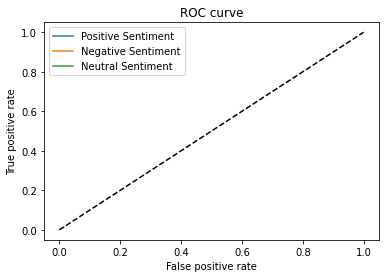

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()